In [69]:
import pandas as pd
import numpy as np
import re
import codecs
import seaborn as sns
sns.set_style("darkgrid")
import matplotlib.pyplot as plt
%matplotlib inline
import operator
import tensorflow as tf
import warnings; warnings.simplefilter('ignore')
import pickle
import copy
pd.set_option('display.max_rows', 500)
from nltk.translate.bleu_score import sentence_bleu

In [2]:
cd ~/Desktop/project_data

/Users/tianqiwang/Desktop/project_data


## data

http://www.sogou.com/labs/resource/ca.php

## reference

https://towardsdatascience.com/seq2seq-model-in-tensorflow-ec0c557e560f
https://github.com/deep-diver/EN-FR-MLT-tensorflow/blob/master/dlnd_language_translationv2.ipynb

## read in data

In [3]:
path = 'news_tensite_xml.dat'
data = pd.read_csv(path, error_bad_lines = False, encoding = 'gb18030')

b'Skipping line 208088: expected 1 fields, saw 2\nSkipping line 208124: expected 1 fields, saw 2\nSkipping line 208136: expected 1 fields, saw 2\nSkipping line 208166: expected 1 fields, saw 2\nSkipping line 208340: expected 1 fields, saw 2\nSkipping line 208508: expected 1 fields, saw 2\nSkipping line 208526: expected 1 fields, saw 2\nSkipping line 216752: expected 1 fields, saw 2\nSkipping line 216806: expected 1 fields, saw 2\nSkipping line 216968: expected 1 fields, saw 2\nSkipping line 217148: expected 1 fields, saw 2\nSkipping line 217328: expected 1 fields, saw 2\nSkipping line 217334: expected 1 fields, saw 2\nSkipping line 217346: expected 1 fields, saw 2\nSkipping line 217388: expected 1 fields, saw 2\nSkipping line 224684: expected 1 fields, saw 2\nSkipping line 224882: expected 1 fields, saw 2\nSkipping line 224930: expected 1 fields, saw 2\nSkipping line 224996: expected 1 fields, saw 2\nSkipping line 225332: expected 1 fields, saw 2\nSkipping line 230834: expected 1 field

b'Skipping line 4748852: expected 1 fields, saw 2\nSkipping line 4748912: expected 1 fields, saw 3\nSkipping line 4749074: expected 1 fields, saw 4\nSkipping line 4749080: expected 1 fields, saw 3\nSkipping line 4749230: expected 1 fields, saw 2\nSkipping line 4749350: expected 1 fields, saw 7\nSkipping line 4749410: expected 1 fields, saw 2\nSkipping line 4749482: expected 1 fields, saw 7\nSkipping line 4749572: expected 1 fields, saw 2\nSkipping line 4749806: expected 1 fields, saw 7\nSkipping line 4750130: expected 1 fields, saw 3\nSkipping line 4750448: expected 1 fields, saw 2\nSkipping line 4750544: expected 1 fields, saw 2\nSkipping line 4750664: expected 1 fields, saw 2\nSkipping line 4750850: expected 1 fields, saw 2\nSkipping line 4750886: expected 1 fields, saw 4\nSkipping line 4751162: expected 1 fields, saw 7\nSkipping line 4751216: expected 1 fields, saw 4\nSkipping line 4751252: expected 1 fields, saw 4\nSkipping line 4751276: expected 1 fields, saw 2\nSkipping line 4751

In [4]:
content = data[data['<doc>'].str.match('^<content>.*</content>$')]
content.index = range(content.shape[0])

title = data[data['<doc>'].str.match('^<contenttitle>.*</contenttitle>$')]
title.index = range(title.shape[0])

links = data[data['<doc>'].str.match('^<url>.*</url>$')]
links.index = range(links.shape[0])

content['title'] = title
content['links'] = links

content['<doc>'] = content['<doc>'].apply(lambda x: x[9:-10])
content['title'] = content['title'].apply(lambda x: x[14:-15])

content.columns = ['content', 'title', 'links']

# remove news with content that starts with '遵守中华人民共和国' and '中国雅虎侠客平台仅提供信息存储空间服务'
content = content.loc[~content['content'].str.startswith('遵守中华人民共和国')]
content = content.loc[~content['content'].str.startswith('中国雅虎侠客平台仅提供信息存储空间服务')]
# remove empty strings
content = content[(content.content != '') & (content.title != '')]

In [5]:
content.head()

,content,title,links
0,中广网唐山６月１２日消息（记者汤一亮 庄胜春）据中国之声《新闻晚高峰》报道，今天（１２日）上...,公安机关销毁１０余万非法枪支 跨国武器走私渐起,<url>http://news.sohu.com/20120612/n345428229....
1,天津卫视求职节目《非你莫属》“晕倒门”事件余波未了，主持人张绍刚前日通过《非你莫属》节目组发...,张绍刚发道歉信网友不认可：他的问题是俯视他人（图）,<url>http://news.sohu.com/20120607/n344998325....
2,临沂（山东），２０１２年６月４日 夫妻“麦客”忙麦收 ６月４日，在山东省临沂市郯城县郯城街道...,＃（关注夏收）（３）夫妻“麦客”忙麦收,<url>http://news.sohu.com/20120604/n344745879....
3,中广网北京６月１３日消息（记者王宇）据中国之声《新闻晚高峰》报道，明天凌晨两场欧洲杯的精彩比...,欧洲杯大战在即 荷兰葡萄牙面临淘汰将背水一战,<url>http://news.sohu.com/20120613/n345535702....
4,环球网记者李亮报道，正在意大利度蜜月的“脸谱”创始人扎克伯格与他华裔妻子的一举一动都处于媒体...,扎克伯格携妻罗马当街吃３０元麦当劳午餐（组图）,<url>http://news.sohu.com/20120601/n344598651....


In [6]:
content = content.drop_duplicates(subset ="content") 

In [71]:
texts = content.content.values.tolist()
titles = content.title.values.tolist()

Text(0.5, 1.0, 'distribution of article length')

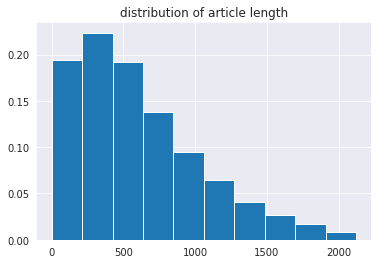

In [72]:
text_length = [len(text) for text in texts]
weights = np.ones_like(text_length)/float(len(text_length))
plt.hist(text_length,weights=weights)
plt.title('distribution of article length')

Text(0.5, 1.0, 'distribution of title length')

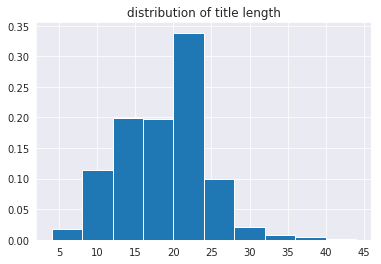

In [73]:
title_length = [len(title) for title in titles]
weights = np.ones_like(title_length)/float(len(title_length))
plt.hist(title_length,weights=weights)
plt.title('distribution of title length')

In [7]:
# select articles with: 50 < content length < 200, title length < 25 
content1 = content[(content.content.str.len() < 200) & (content.content.str.len() > 50) &(content.title.str.len() < 25)]
content1.shape

(112742, 3)

In [8]:
texts = content1.content.values.tolist()
titles = content1.title.values.tolist()

In [9]:
print('number of articles: {}'.format(len(content1)))

number of articles: 112742


In [10]:
# save data
with open("texts.txt", "wb") as fp:
    pickle.dump(texts, fp)
with open("titles.txt", "wb") as fp: 
    pickle.dump(titles, fp)

## Check Point

In [11]:
# read data
with open("texts.txt", "rb") as fp: 
    texts = pickle.load(fp)
    
with open("titles.txt", "rb") as fp: 
    titles = pickle.load(fp) 

In [12]:
# split training and validation dataset

In [13]:
special_char = ['“','”', '《', '》','\u3000', '【', '】', '']

In [14]:
texts = [''.join([t for t in t1 if t not in special_char] ) for t1 in texts]
titles = [''.join([t for t in t1 if t not in special_char] ) for t1 in titles]

In [15]:
training_size = 101467
texts1 = texts[:training_size]
titles1 = titles[:training_size]

texts_validation = texts[training_size:]
titles_validation = titles[training_size:]

# preprocessing

In [16]:
def add_to_vocabulary(texts):
    tmp_vocab, count = {}, {}
    for text in texts:
        for char in text:
            if char not in tmp_vocab:
                idx = len(tmp_vocab)
                tmp_vocab[char] = idx
                count[idx] = 1
            else:
                count[tmp_vocab[char]] += 1
    return tmp_vocab, count

def build_vocab(tmp_vocab, count):
    inverse_map = {v: k for k,v in tmp_vocab.items()}
    vocab = {}
    sorted_words = sorted(count.items(), key=operator.itemgetter(1), reverse=True)
  
    for i, (word_idx, count) in zip(range(vocab_size-4), sorted_words):
        vocab[inverse_map[word_idx]] = i
    
    vocab['<PAD>'] = len(vocab)
    # input to the first timestamp of the decoder
    vocab['<GO>'] = len(vocab)
    vocab['<EOS>'] = len(vocab)
    vocab['<UNK>'] = len(vocab)
  
    reverse_vocab = {v: k for k,v in vocab.items()}
  
    return reverse_vocab, vocab

In [17]:
tmp_vocab, count = add_to_vocabulary(texts1+titles1)
print('the data contains {} vocabularies'.format(len(tmp_vocab)))

the data contains 6508 vocabularies


In [18]:
# build vocabulary

vocab_size = len(tmp_vocab)
source_int_to_vocab, source_vocab_to_int = build_vocab(tmp_vocab, count)
target_int_to_vocab, target_vocab_to_int = source_int_to_vocab, source_vocab_to_int 

In [19]:
# convert texts to ids

source_text = [[source_vocab_to_int.get(char, source_vocab_to_int['<UNK>']) for char in text] for text in texts1]
target_text = [[target_vocab_to_int.get(char, target_vocab_to_int['<UNK>']) for char in title] 
               + [target_vocab_to_int['<EOS>']] for title in titles1]

In [20]:
 pickle.dump(((source_text, target_text), 
              (source_vocab_to_int, target_vocab_to_int),
              (source_int_to_vocab, target_int_to_vocab)), 
            open('preprocess.p', 'wb'))

# check Point

In [21]:
def load_preprocess():
    with open('preprocess.p', mode='rb') as in_file:
        return pickle.load(in_file)

In [22]:
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = load_preprocess()

# Build the network

In [23]:
def enc_dec_model_inputs():
    inputs = tf.placeholder(tf.int32, [None, None], name='input')
    targets = tf.placeholder(tf.int32, [None, None], name='targets') 
    
    target_sequence_length = tf.placeholder(tf.int32, [None], name='target_sequence_length')
    max_target_len = tf.reduce_max(target_sequence_length)    
    
    return inputs, targets, target_sequence_length, max_target_len

In [24]:
def hyperparam_inputs():
    lr_rate = tf.placeholder(tf.float32, name='lr_rate')
    keep_prob = tf.placeholder(tf.float32, name='keep_prob')
    
    return lr_rate, keep_prob

In [25]:
def process_decoder_input(target_data, target_vocab_to_int, batch_size):
    """
    Preprocess target data for encoding
    :return: Preprocessed target data
    """
    # get '<GO>' id
    go_id = target_vocab_to_int['<GO>']
    
    after_slice = tf.strided_slice(target_data, [0, 0], [batch_size, -1], [1, 1])
    after_concat = tf.concat( [tf.fill([batch_size, 1], go_id), after_slice], 1)
    
    return after_concat

In [26]:
def encoding_layer(rnn_inputs, rnn_size, num_layers, keep_prob, 
                   source_vocab_size, 
                   encoding_embedding_size):
    """
    :return: tuple (RNN output, RNN state)
    """
    embed = tf.contrib.layers.embed_sequence(rnn_inputs, 
                                             vocab_size=source_vocab_size, 
                                             embed_dim=encoding_embedding_size)
    
    stacked_cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.LSTMCell(rnn_size), keep_prob) for _ in range(num_layers)])
    
    outputs, state = tf.nn.dynamic_rnn(stacked_cells, 
                                       embed, 
                                       dtype=tf.float32)
    return outputs, state

In [27]:
def decoding_layer_train(encoder_state, dec_cell, dec_embed_input, 
                         target_sequence_length, max_summary_length, 
                         output_layer, keep_prob):
    """
    Create a training process in decoding layer 
    :return: BasicDecoderOutput containing training logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    # for only input layer
    helper = tf.contrib.seq2seq.TrainingHelper(dec_embed_input, 
                                               target_sequence_length)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)

    # unrolling the decoder layer
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_summary_length)
    return outputs

In [28]:
def decoding_layer_infer(encoder_state, dec_cell, dec_embeddings, start_of_sequence_id,
                         end_of_sequence_id, max_target_sequence_length,
                         vocab_size, output_layer, batch_size, keep_prob):
    """
    Create a inference process in decoding layer 
    :return: BasicDecoderOutput containing inference logits and sample_id
    """
    dec_cell = tf.contrib.rnn.DropoutWrapper(dec_cell, 
                                             output_keep_prob=keep_prob)
    
    helper = tf.contrib.seq2seq.GreedyEmbeddingHelper(dec_embeddings, 
                                                      tf.fill([batch_size], start_of_sequence_id), 
                                                      end_of_sequence_id)
    
    decoder = tf.contrib.seq2seq.BasicDecoder(dec_cell, 
                                              helper, 
                                              encoder_state, 
                                              output_layer)
    
    outputs, _, _ = tf.contrib.seq2seq.dynamic_decode(decoder, 
                                                      impute_finished=True, 
                                                      maximum_iterations=max_target_sequence_length)
    return outputs

In [29]:
def decoding_layer(dec_input, encoder_state,
                   target_sequence_length, max_target_sequence_length,
                   rnn_size,
                   num_layers, target_vocab_to_int, target_vocab_size,
                   batch_size, keep_prob, decoding_embedding_size):
    """
    Create decoding layer
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    target_vocab_size = len(target_vocab_to_int)
    dec_embeddings = tf.Variable(tf.random_uniform([target_vocab_size, decoding_embedding_size]))
    dec_embed_input = tf.nn.embedding_lookup(dec_embeddings, dec_input)
    
    cells = tf.contrib.rnn.MultiRNNCell([tf.contrib.rnn.LSTMCell(rnn_size) for _ in range(num_layers)])
    
    with tf.variable_scope("decode"):
        output_layer = tf.layers.Dense(target_vocab_size)
        train_output = decoding_layer_train(encoder_state, 
                                            cells, 
                                            dec_embed_input, 
                                            target_sequence_length, 
                                            max_target_sequence_length, 
                                            output_layer, 
                                            keep_prob)

    with tf.variable_scope("decode", reuse=True):
        infer_output = decoding_layer_infer(encoder_state, 
                                            cells, 
                                            dec_embeddings, 
                                            target_vocab_to_int['<GO>'], 
                                            target_vocab_to_int['<EOS>'], 
                                            max_target_sequence_length, 
                                            target_vocab_size, 
                                            output_layer,
                                            batch_size,
                                            keep_prob)

    return (train_output, infer_output)

In [30]:
def seq2seq_model(input_data, target_data, keep_prob, batch_size,
                  target_sequence_length,
                  max_target_sentence_length,
                  source_vocab_size, target_vocab_size,
                  enc_embedding_size, dec_embedding_size,
                  rnn_size, num_layers, target_vocab_to_int):
    """
    Build the Sequence-to-Sequence model
    :return: Tuple of (Training BasicDecoderOutput, Inference BasicDecoderOutput)
    """
    enc_outputs, enc_states = encoding_layer(input_data, 
                                             rnn_size, 
                                             num_layers, 
                                             keep_prob, 
                                             source_vocab_size, 
                                             enc_embedding_size)
    
    dec_input = process_decoder_input(target_data, 
                                      target_vocab_to_int, 
                                      batch_size)
    
    train_output, infer_output = decoding_layer(dec_input,
                                               enc_states, 
                                               target_sequence_length, 
                                               max_target_sentence_length,
                                               rnn_size,
                                              num_layers,
                                              target_vocab_to_int,
                                              target_vocab_size,
                                              batch_size,
                                              keep_prob,
                                              dec_embedding_size)
    
    return train_output, infer_output

# Network Training

In [31]:
display_step = 500

epochs = 10
batch_size = 64

rnn_size = 128
num_layers = 3

encoding_embedding_size = 200
decoding_embedding_size = 200

learning_rate = 0.001
keep_probability = 1

In [32]:
save_path = 'checkpoints/dev'
(source_int_text, target_int_text), (source_vocab_to_int, target_vocab_to_int), _ = load_preprocess()
max_target_sentence_length = max([len(sentence) for sentence in source_int_text])

train_graph = tf.Graph()
with train_graph.as_default():
    input_data, targets, target_sequence_length, max_target_sequence_length = enc_dec_model_inputs()
    lr, keep_prob = hyperparam_inputs()
    
    train_logits, inference_logits = seq2seq_model(tf.reverse(input_data, [-1]),
                                                   targets,
                                                   keep_prob,
                                                   batch_size,
                                                   target_sequence_length,
                                                   max_target_sequence_length,
                                                   len(source_vocab_to_int),
                                                   len(target_vocab_to_int),
                                                   encoding_embedding_size,
                                                   decoding_embedding_size,
                                                   rnn_size,
                                                   num_layers,
                                                   target_vocab_to_int)
    
    training_logits = tf.identity(train_logits.rnn_output, name='logits')
    inference_logits = tf.identity(inference_logits.sample_id, name='predictions')

    # - Returns a mask tensor representing the first N positions of each cell.
    masks = tf.sequence_mask(target_sequence_length, max_target_sequence_length, dtype=tf.float32, name='masks')

    with tf.name_scope("optimization"):
        # Loss function - weighted softmax cross entropy
        cost = tf.contrib.seq2seq.sequence_loss(
            training_logits,
            targets,
            masks)

        # Optimizer
        optimizer = tf.train.AdamOptimizer(lr)

        # Gradient Clipping
        gradients = optimizer.compute_gradients(cost)
        capped_gradients = [(tf.clip_by_value(grad, -1., 1.), var) for grad, var in gradients if grad is not None]
        train_op = optimizer.apply_gradients(capped_gradients)

In [33]:
def pad_sentence_batch(sentence_batch, pad_int):
    """Pad sentences with <PAD> so that each sentence of a batch has the same length"""
    max_sentence = max([len(sentence) for sentence in sentence_batch])
    return [sentence + [pad_int] * (max_sentence - len(sentence)) for sentence in sentence_batch]


def get_batches(sources, targets, batch_size, source_pad_int, target_pad_int):
    """Batch targets, sources, and the lengths of their sentences together"""
    for batch_i in range(0, len(sources)//batch_size):
        start_i = batch_i * batch_size

        # Slice the right amount for the batch
        sources_batch = sources[start_i:start_i + batch_size]
        targets_batch = targets[start_i:start_i + batch_size]

        # Pad
        pad_sources_batch = np.array(pad_sentence_batch(sources_batch, source_pad_int))
        pad_targets_batch = np.array(pad_sentence_batch(targets_batch, target_pad_int))

        # Need the lengths for the _lengths parameters
        pad_targets_lengths = []
        for target in pad_targets_batch:
            pad_targets_lengths.append(len(target))

        pad_source_lengths = []
        for source in pad_sources_batch:
            pad_source_lengths.append(len(source))

        yield pad_sources_batch, pad_targets_batch, pad_source_lengths, pad_targets_lengths

In [34]:
def get_accuracy(target, logits):
    """
    Calculate accuracy
    """
    max_seq = max(target.shape[1], logits.shape[1])
    if max_seq - target.shape[1]:
        target = np.pad(
            target,
            [(0,0),(0,max_seq - target.shape[1])],
            'constant')
    if max_seq - logits.shape[1]:
        logits = np.pad(
            logits,
            [(0,0),(0,max_seq - logits.shape[1])],
            'constant')

    return np.mean(np.equal(target, logits))

In [36]:
# Split data to training and validation sets

#train_source = source_int_text[batch_size:]
#train_target = target_int_text[batch_size:]
#valid_source = source_int_text[:batch_size]
#valid_target = target_int_text[:batch_size]

In [51]:
train_source = source_int_text[:90192]
train_target = target_int_text[:90192]
valid_source = source_int_text[90192:]
valid_target = target_int_text[90192:]

In [52]:

(valid_sources_batch, valid_targets_batch, valid_sources_lengths, valid_targets_lengths ) = next(get_batches(valid_source,
                                                                                                             valid_target,
                                                                                                             batch_size,
                                                                                                             source_vocab_to_int['<PAD>'],
                                                                                                             target_vocab_to_int['<PAD>']))                                                                                                  
with tf.Session(graph=train_graph) as sess:
    sess.run(tf.global_variables_initializer())

    for epoch_i in range(epochs):
        print('running epoch {}'.format(epoch_i))
        for batch_i, (source_batch, target_batch, sources_lengths, targets_lengths) in enumerate(
                get_batches(train_source, train_target, batch_size,
                            source_vocab_to_int['<PAD>'],
                            target_vocab_to_int['<PAD>'])):

            _, loss = sess.run(
                [train_op, cost],
                {input_data: source_batch,
                 targets: target_batch,
                 lr: learning_rate,
                 target_sequence_length: targets_lengths,
                 keep_prob: keep_probability})

            if batch_i % display_step == 0 and batch_i > 0:
                batch_train_logits = sess.run(
                    inference_logits,
                    {input_data: source_batch,
                     target_sequence_length: targets_lengths,
                     keep_prob: 1})

                batch_valid_logits = sess.run(
                    inference_logits,
                    {input_data: valid_sources_batch,
                     target_sequence_length: valid_targets_lengths,
                     keep_prob: 1})

                train_acc = get_accuracy(target_batch, batch_train_logits)
                valid_acc = get_accuracy(valid_targets_batch, batch_valid_logits)
                
                #valid_acc = get_bleu(valid_targets_batch, batch_valid_logits)

                print('Epoch {:>3} Batch {:>4}/{} - Train Accuracy: {:>6.4f}, Validation Accuracy: {:>6.4f}, Loss: {:>6.4f}'
                      .format(epoch_i, batch_i, len(source_int_text) // batch_size, train_acc, valid_acc, loss))

    # Save Model
    saver = tf.train.Saver()
    saver.save(sess, save_path)
    print('Model Trained and Saved')

running epoch 0
Epoch   0 Batch  500/1585 - Train Accuracy: 0.0048, Validation Accuracy: 0.0034, Loss: 4.1184
Epoch   0 Batch 1000/1585 - Train Accuracy: 0.0482, Validation Accuracy: 0.0000, Loss: 2.8071
running epoch 1
Epoch   1 Batch  500/1585 - Train Accuracy: 0.0075, Validation Accuracy: 0.0109, Loss: 3.9235
Epoch   1 Batch 1000/1585 - Train Accuracy: 0.0516, Validation Accuracy: 0.0061, Loss: 2.0675
running epoch 2
Epoch   2 Batch  500/1585 - Train Accuracy: 0.0088, Validation Accuracy: 0.0041, Loss: 3.8257
Epoch   2 Batch 1000/1585 - Train Accuracy: 0.0666, Validation Accuracy: 0.0143, Loss: 1.7544
running epoch 3
Epoch   3 Batch  500/1585 - Train Accuracy: 0.0143, Validation Accuracy: 0.0177, Loss: 3.6655
Epoch   3 Batch 1000/1585 - Train Accuracy: 0.0571, Validation Accuracy: 0.0088, Loss: 1.5024
running epoch 4
Epoch   4 Batch  500/1585 - Train Accuracy: 0.0143, Validation Accuracy: 0.0109, Loss: 3.5338
Epoch   4 Batch 1000/1585 - Train Accuracy: 0.0618, Validation Accuracy: 0

In [53]:
def save_params(params):
    with open('params_100.p', 'wb') as out_file:
        pickle.dump(params, out_file)


def load_params():
    with open('params_100.p', mode='rb') as in_file:
        return pickle.load(in_file)

In [54]:
save_params(save_path)

# Check Point

In [55]:
import tensorflow as tf
import numpy as np
#import problem_unittests as tests

_, (source_vocab_to_int, target_vocab_to_int), (source_int_to_vocab, target_int_to_vocab) = load_preprocess()
load_path = load_params()

# Translate

In [56]:
def sentence_to_seq(sentence, vocab_to_int):
    results = []
    for word in sentence:
        if word in vocab_to_int:
            results.append(vocab_to_int[word])
        else:
            results.append(vocab_to_int['<UNK>'])
            
    return results

In [60]:
predicted_titles = []

loaded_graph = tf.Graph()
with tf.Session(graph=loaded_graph) as sess:
    
    # Load saved model
    loader = tf.train.import_meta_graph(load_path + '.meta')
    loader.restore(sess, load_path)

    input_data = loaded_graph.get_tensor_by_name('input:0')
    logits = loaded_graph.get_tensor_by_name('predictions:0')
    target_sequence_length = loaded_graph.get_tensor_by_name('target_sequence_length:0')
    keep_prob = loaded_graph.get_tensor_by_name('keep_prob:0')
    
    for translate_sentence, actual_title in zip(texts_validation, titles_validation):
        translate_sentence_int = sentence_to_seq(translate_sentence, source_vocab_to_int)
        translate_logits = sess.run(logits, {input_data: [translate_sentence_int]*batch_size,
                                         target_sequence_length: [len(translate_sentence_int)*2]*batch_size,
                                         keep_prob: 1.0})[0]
        predicted_title = "".join([target_int_to_vocab.get(char, '<UNK>') for char in translate_logits])
        predicted_titles.append(predicted_title)
        #print('  Article: {}'.format(translate_sentence))
        #print('  Predicted Title: {}'.format(predicted_title))
        #print('  Actual Title: {}'.format(actual_title))

INFO:tensorflow:Restoring parameters from checkpoints/dev


INFO:tensorflow:Restoring parameters from checkpoints/dev


In [58]:
from rouge.rouge import rouge_n_sentence_level

In [61]:
results = pd.DataFrame({'article': texts_validation,'actual title': titles_validation, 
                        'predicted_title': predicted_titles})
results = results[results['predicted_title'].notna()]
results['predicted_title'] = results['predicted_title'].apply(lambda x: x[:-5])
results['actual'] = results['actual title'].apply(lambda x: list(x))
results['predicted'] = results['predicted_title'].apply(lambda x: list(x))
results['bleu_scores'] = results.apply(lambda row: sentence_bleu([row['actual']], row['predicted'], weights = (0.5, 0.5)), axis=1)
predicted = results.predicted.to_list()
actual = results.actual.to_list()
results = results[['article', 'actual title', 'predicted_title', 'bleu_scores']]

In [63]:
rouge_2_f = []
for reference, summary in zip(actual, predicted):
    _,_, f = rouge_n_sentence_level(summary, reference, 2)
    rouge_2_f.append(f)

In [66]:
rouge_1_f = []
for reference, summary in zip(actual, predicted):
    _,_, f = rouge_n_sentence_level(summary, reference, 1)
    rouge_1_f.append(f)

In [67]:
print('mean BLEU-2: {}'.format(np.mean(results['bleu_scores'])))
print('mean ROUGE-2-F: {}'.format(np.mean(rouge_2_f)))
print('mean ROUGE-1-F: {}'.format(np.mean(rouge_1_f)))

mean BLEU-2: 0.10118944183961945
mean ROUGE-2-F: 0.017269889334550155
mean ROUGE-1-F: 0.06766334174105129


In [70]:
results.sort_values(by = 'bleu_scores', ascending = False)

,article,actual title,predicted_title,bleu_scores
1892,地点：菏泽器材：尼康Ｄ３００Ｓ自述：疲惫的孩子独自在三轮车里睡着了。点评：呼噜娃要注意...,后惫箱（图）,［组图］（２）,0.654654
519,中新网７月１２日电据香港媒体报道，港股１２日早低开６３点，跌势迅速扩大，恒指最新报１９２１２...,港股１２日开市跌２０７点,快讯：两市低开沪指跌０．２２％报２２１点,0.632456
7651,中新网７月１２日电据台湾媒体报道，台北股市７月１２日开盘下跌１７．０３点，加权股价指数成为７...,台股７月１２日开盘下跌１７．０３点,快讯：两市低开沪指跌０．２２％报２２１点,0.591608
5137,中新网６月２０日电据台湾媒体报道，台北股市２０日开盘上涨３２．１９点，加权股价指数成为７３０...,台股６月２０日开盘上涨３２．１９点,快讯：两市低开沪指跌０．２２％报２２１点,0.591608
646,中新网６月２６日电据台湾媒体报道，台北股市２６日开盘下跌２３．６０点，加权股价指数成为７１４...,台股６月２６日开盘下跌２３．６０点,快讯：两市低开沪指跌０．２２％报２２１点,0.591608
7168,版本：海豚出版社２０１２年７月定价：２６０．００元董桥的文字，蕴藉有致，短短的小品，却...,英华沉浮录（图）,［组图］人生（２）,0.577350
583,据新华社中国海监８３船７月２日电正在南海我国管辖海域执行定期维权巡航任务的中国海监编队２日进...,南海巡航编队进行海上演练,中国航天员在京海南省海域,0.577350
79,据新华社石家庄７月３日电记者从河北省平山县委办公室了解到，７月３日７时１２分，位于平山县小觉...,河北一工厂高热蒸汽致死６人,广西一家发生爆炸致１人死亡,0.554700
10720,中新网６月１２日电据台湾媒体报道，台北股市１２日开盘下跌８８．７７点，加权股价指数成为７０３...,台股１２日开盘下跌８８．７７点,快讯：两市低开沪指跌０．２２％报２２１点,0.547723
5783,地点：曲阜器材：佳能３５０Ｄ自述：室外工作，烈日当头，全力遮光。点评：电脑和头脑都需要冷静。,效裹不错（图）,［组图］人生（２０）,0.547723
